#References
https://levelup.gitconnected.com/how-to-remove-stopwords-from-text-in-python-9e9fbfcbca8d

https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python

https://stackoverflow.com/questions/44633571/how-can-i-get-the-feature-names-from-sklearn-truncatedsvd-object

https://stackoverflow.com/questions/46917835/plot-data-on-number-line-and-colour


#Data Exploration

---



In [ ]:
import pandas as pd
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.sparse import coo_matrix, hstack
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
drive.mount('/content/drive/')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive/


In [ ]:
data = "/content/drive/My Drive/Colab Notebooks/train-balanced-sarcasm.csv"

In [ ]:
df = pd.read_csv(data)
df = df.dropna()

In [ ]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


The below histogram of labels show that the data is **balanced**

AxesSubplot(0.125,0.125;0.775x0.755)


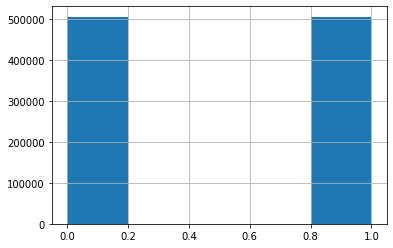

In [ ]:
hist = df["label"].hist(bins=5)
print(hist)

The above dataset is balanced.

Literature indicates that bag of bigrams provides the best accuracy on the data.
Also, they have only used the comment feature.

Since bag of bigrams considers pairs of contiguous words, it cannot be applied to author & subreddit columns (they are only 1 word entries).


For author & subreddit, there is no semantic information to be extracted. Hence, if it is used as a feature to train but a test instance is from a different author & subreddit, the model may not scale well. For this reason, we drop the author and subreddit features.



The created_utc field provides more granular data than date field. It is possible that what qualifies as sarcasm changes over time. Hence, we will use the year of a post as a possible feature (Data is from 2009 to 2016).

In [ ]:
labels = df["label"]
df["year"] = df["created_utc"].apply(lambda t: datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S").year)
raw_features = df.drop(["label", "author", "subreddit", "created_utc", "date"], axis=1)

Data Split - Train (60%), Validation (20%), Test (20%)


---


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(raw_features, labels, test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
# X_train = X_train.values
# X_test = X_test.values
# Y_train = Y_train.values
# Y_test = Y_test.values

The following data exploration will be done on only the train data.


Data Pre-processing for "comment" and "parent_comment":


---


  1. Convert all words to lower case. This will increase the frequency of the same word regardless of case
  2. Remove stopwords - Stopwords can prevent the same pairs of words from appearing contiguously. Removing them will help to capture context in bag of bigrams and other feature extraction methods.

Note: The SARC paper mentions that they have removed URLs and limited the data to ASCII characters only. Hence, our data cleaning can be restricted to methods that will aid in extracting semantic information.

In [ ]:
stop_words = nltk.corpus.stopwords.words('english')
stopwords_dict = Counter(stop_words)

In [ ]:
def clean(input, stopwords_dict):
  #convert to lower case
  lower = input.lower()

  #remove stop words
  #https://levelup.gitconnected.com/how-to-remove-stopwords-from-text-in-python-9e9fbfcbca8d
  #https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python

  tokens = word_tokenize(lower)
  cleaned = ' '.join([token for token in tokens if token not in stopwords_dict])
  return cleaned

In [ ]:
processed_comment = X_train["comment"].apply(lambda c : clean(c, stopwords_dict))
processed_parent_comment = X_train["parent_comment"].apply(lambda c : clean(c, stopwords_dict))

#Bag of Bigrams


---



Collated Function:

In [ ]:
#The following cells evaluate the different parts of this function
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

def get_bob_norm_csr(raw_features):
  processed_comment = raw_features["comment"].apply(lambda c : clean(c, stopwords_dict))
  processed_parent_comment =  raw_features["parent_comment"].apply(lambda c : clean(c, stopwords_dict))

  #For comment
  vec = CountVectorizer(binary=True, ngram_range=(2,2), min_df=2)
  bob_comment = vec.fit_transform(processed_comment.values)
  #For parent_comment
  vec = CountVectorizer(binary=True, ngram_range=(2,2), min_df=2)
  bob_parent_comment = vec.fit_transform(processed_parent_comment.values)

  reshaped_score = np.array(raw_features["score"]).reshape(len(raw_features["score"]), 1)
  reshaped_ups = np.array(raw_features["ups"]).reshape(len(raw_features["ups"]), 1)
  reshaped_downs = np.array(raw_features["downs"]).reshape(len(raw_features["downs"]), 1)
  reshaped_year = np.array(raw_features["year"]).reshape(len(raw_features["year"]), 1)

  combined_csr = hstack([bob_comment,bob_parent_comment, reshaped_score, reshaped_ups, reshaped_downs, reshaped_year]).tocsr()

  norm_csr = normalize(combined_csr)
  svd = TruncatedSVD(n_components=1, random_state=42)
  svd = svd.fit(norm_csr)
  svd_trans = svd.transform(norm_csr)

  return svd_trans


Create Bag of Bigrams for comment & parent_comment

In [ ]:
#For comment
vec = CountVectorizer(binary=True, ngram_range=(2,2), min_df=2)
bob_comment = vec.fit_transform(processed_comment.values)

In [ ]:
#For parent_comment
vec = CountVectorizer(binary=True, ngram_range=(2,2), min_df=2)
bob_parent_comment = vec.fit_transform(processed_parent_comment.values)

Truncated Singular Value Decomposition (TSVD) on data with Bag of bigrams (to check if data is/can be made linearly separable)


---
Bag of Bigrams generates a large number of features for a single instance (In the baseline model, a single comment has ~1.9 million features). Reducing its dimensionality is useful to interpret the features and mitigate the **Curse of Dimensionality** (to reduce risk of overfitting)


In [ ]:
reshaped_score = np.array(X_train["score"]).reshape(len(X_train["score"]), 1)
reshaped_ups = np.array(X_train["ups"]).reshape(len(X_train["ups"]), 1)
reshaped_downs = np.array(X_train["downs"]).reshape(len(X_train["downs"]), 1)
reshaped_year = np.array(X_train["year"]).reshape(len(X_train["year"]), 1)

train_csr = hstack([bob_comment,bob_parent_comment, reshaped_score, reshaped_ups, reshaped_downs, reshaped_year]).tocsr()

Normalizing train_csr

In [ ]:
from sklearn.preprocessing import normalize
norm_train_csr = normalize(train_csr)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=0)
svd = svd.fit(norm_train_csr)
svd_train = svd.transform(norm_train_csr)

In [ ]:
svd_df = pd.DataFrame(data = svd_train, columns = ["PC 1", "PC 2"])
svd_df.head()

,PC 1,PC 2
0,0.999989,-0.004731
1,0.999993,-0.003330
2,0.999995,-0.001724
3,0.999991,-0.003978
4,0.999991,-0.003978


In [ ]:
# https://stackoverflow.com/questions/44633571/how-can-i-get-the-feature-names-from-sklearn-truncatedsvd-object
# len(svd.components_)
" ".join([
    "%+0.12f*%s" % (coef, feat)
    for coef, feat in zip(svd.components_[0], X_train.columns)
])

'+0.000000002455*comment +0.000000001637*score +0.000000002456*ups +0.000000001637*downs +0.000000001638*parent_comment +0.000000001638*year'

The reduced dimensionality shows PC1 is sufficient to capture most of the  data's variance.

The weights for each feature resulting in PC1 are printed above. We see that the comment and ups are the features capturing the most variance in the data.

Since the parent_comment weight is low, we can deduce that whether a comment is sarcastic or not is uncorrelated with its parent.

Vizualizing this data:

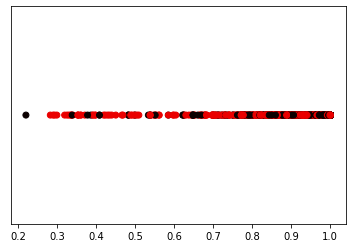

In [ ]:
# https://stackoverflow.com/questions/46917835/plot-data-on-number-line-and-colour
#red is 0, black is 1
import matplotlib.pyplot as plt

plt.scatter(svd_df["PC 1"], np.zeros_like(svd_df["PC 1"]), c=Y_train, cmap="hot_r", vmin=-2)
# plt.scatter(svd_df["PC 1"], svd_df["PC 2"], c=Y_train, cmap="hot_r", vmin=-2)

plt.yticks([])
plt.show()

Based on the plot above, the reduced dimension of the training data is not linearly separable and logistic regression is unlikely to perform well on it.

#Logistic Regression on the processed data (Bag of Bigrams + Normalizing + SVD with 1 PC):

---



In [ ]:
logistic_train_data = get_bob_norm_csr(X_train)
logistic_val_data = get_bob_norm_csr(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 27 epochs took 6 seconds
Accuracy:  0.498844945709975
F1 Score:  0.0


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished


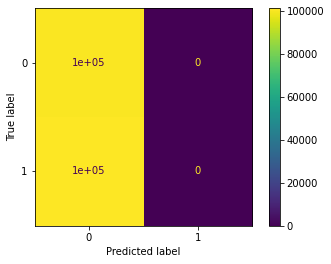

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

sk_log_reg = LogisticRegression(verbose=1, solver='sag', penalty='l2', max_iter=40)
model = sk_log_reg.fit(logistic_train_data, Y_train)

predictions = model.predict(logistic_val_data)
accuracy = model.score(logistic_val_data, Y_val)
print("Accuracy: ", accuracy)
f1 = f1_score(Y_val, predictions)
print("F1 Score: ", f1)

conf_mat = confusion_matrix(Y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
disp.plot()
plt.show()

While PC1 captured a large proportion of the data's variance, the performance is poor on the validation data. This is expected as the SVD plot shows the data is not linearly separable.


The baseline model using only the comment is more performant on SARC but it suffers from overfit due to Curse of Dimensionality (fails on new data).

#TFIDF (with Bag of Bigrams) - applied to "comment" and "parent_comment"



---



Collated function:

In [ ]:
#The following cells evaluate the different parts of this function
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

def get_tfidf_norm_csr(raw_features, max_features=160000):
  processed_comment = raw_features["comment"].apply(lambda c : clean(c, stopwords_dict))
  processed_parent_comment =  raw_features["parent_comment"].apply(lambda c : clean(c, stopwords_dict))

  #For comment
  # vec = TfidfVectorizer(ngram_range=(2, 2), max_features=max_features, min_df=2)
  vec = TfidfVectorizer(ngram_range=(2, 2), min_df=2)
  tfidf_comment = vec.fit_transform(processed_comment.values)
  #For parent_comment
  # vec = TfidfVectorizer(ngram_range=(2, 2), max_features=max_features, min_df=2)
  vec = TfidfVectorizer(ngram_range=(2, 2), min_df=2)
  tfidf_parent_comment = vec.fit_transform(processed_parent_comment.values)

  reshaped_score = np.array(raw_features["score"]).reshape(len(raw_features["score"]), 1)
  reshaped_ups = np.array(raw_features["ups"]).reshape(len(raw_features["ups"]), 1)
  reshaped_downs = np.array(raw_features["downs"]).reshape(len(raw_features["downs"]), 1)
  reshaped_year = np.array(raw_features["year"]).reshape(len(raw_features["year"]), 1)

  combined_csr = hstack([tfidf_comment,tfidf_parent_comment, reshaped_score, reshaped_ups, reshaped_downs, reshaped_year]).tocsr()

  norm_csr = normalize(combined_csr)
  svd = TruncatedSVD(n_components=max_features, random_state=42)
  svd = svd.fit(norm_csr)
  svd_trans = svd.transform(norm_csr)

  return svd_trans


In [ ]:
tfid_vec = TfidfVectorizer(ngram_range=(2, 2), max_features=50000, min_df=2)

In [ ]:
tfidf_comment = vec.fit_transform(processed_comment.values)
tfidf_parent_comment = vec.fit_transform(processed_parent_comment.values)

In [ ]:
tfidf_comment.shape

(606463, 269201)

Truncated Singular Value Decomposition (TSVD) on data with TF-IDF


---



In [ ]:
reshaped_score = np.array(X_train["score"]).reshape(len(X_train["score"]), 1)
reshaped_ups = np.array(X_train["ups"]).reshape(len(X_train["ups"]), 1)
reshaped_downs = np.array(X_train["downs"]).reshape(len(X_train["downs"]), 1)
reshaped_year = np.array(X_train["year"]).reshape(len(X_train["year"]), 1)

tfidf_train_csr = hstack([tfidf_comment,tfidf_parent_comment, reshaped_score, reshaped_ups, reshaped_downs, reshaped_year]).tocsr()

Normalizing train_csr

In [ ]:
from sklearn.preprocessing import normalize
norm_tfidf_train_csr = normalize(tfidf_train_csr)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=0)
svd = svd.fit(norm_tfidf_train_csr)
svd_train = svd.transform(norm_tfidf_train_csr)

In [ ]:
tfidf_svd_df = pd.DataFrame(data = svd_train, columns = ["PC 1", "PC 2"])
tfidf_svd_df.head()

,PC 1,PC 2
0,0.999989,-0.004731
1,0.999993,-0.003330
2,0.999995,-0.001724
3,0.999991,-0.003978
4,0.999991,-0.003978


In [ ]:
# https://stackoverflow.com/questions/44633571/how-can-i-get-the-feature-names-from-sklearn-truncatedsvd-object
# len(svd.components_)
" ".join([
    "%+0.12f*%s" % (coef, feat)
    for coef, feat in zip(svd.components_[0], X_train.columns)
])

'+0.000000002455*comment +0.000000001637*score +0.000000002456*ups +0.000000001637*downs +0.000000001638*parent_comment +0.000000001638*year'

The reduced dimensionality shows PC1 is sufficient to capture most of the  data's variance.

The weights for each feature resulting in PC1 are printed above. We see that the **comment and year are the features capturing the most variance in the data.**


Visualizing this:

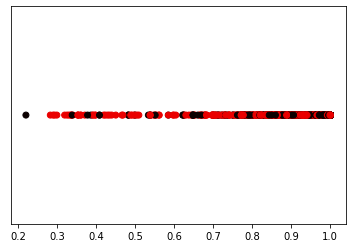

In [ ]:
# https://stackoverflow.com/questions/46917835/plot-data-on-number-line-and-colour
#red is 0, black is 1
import matplotlib.pyplot as plt

plt.scatter(tfidf_svd_df["PC 1"], np.zeros_like(tfidf_svd_df["PC 1"]), c=Y_train, cmap="hot_r", vmin=-2)
# plt.scatter(svd_df["PC 1"], svd_df["PC 2"], c=Y_train, cmap="hot_r", vmin=-2)

plt.yticks([])
plt.show()

Like the Bag of Bigrams plot, the reduced dimension of the TF-IDF training data is not linearly separable and logistic regression is unlikely to perform well on it.

#Logistic Regression on the processed data (TF-IDF + Normalizing + SVD with 1 PC):

---



In [ ]:
logistic_train_data = get_tfidf_norm_csr(X_train)
logistic_val_data = get_tfidf_norm_csr(X_val)

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

sk_log_reg = LogisticRegression(verbose=1, solver='sag', penalty='l2', max_iter=40)
model = sk_log_reg.fit(logistic_train_data, Y_train)

predictions = model.predict(logistic_val_data)
accuracy = model.score(logistic_val_data, Y_val)
print("Accuracy: ", accuracy)
f1 = f1_score(Y_val, predictions)
print("F1 Score: ", f1)

conf_mat = confusion_matrix(Y_val, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model.classes_)
disp.plot()
plt.show()

PC1 captures most of the variance in the data but poor validation performance - expected since data not linearly separable.